In [2]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime

CMAP = "Blues"

# Coastal Erosion Notebook

## Summary
This notebook takes advantage of a time series of Landsat-8 to produce an annual coastline product. 

## Overview
This product is produced, by loading in Landsat-8 data on an annual basis. For each scene a wofs product is produced to identify pixels containing water, as well as cloud and shadows masked. (This step could be replaced in further iterations by using pre-loaded wofs products to increase the computatoinal efficiency). Each scene is matched with it's equivalent tidal height and filtered images within a certain tidal range. Summary annual products are then produced, then shorelines extracted. 

This notebook takes advantage of DASK.

## Import Required DC utils

In [3]:
# import required datacube modules
from utils_sac.interactive_maps import display_map
from utils_sac.clean_mask import landsat_qa_clean_mask
import utils_sac.waterline_functions_deaafrica as waterline_funcs
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify

import datacube
dc = datacube.Datacube(app='wofs dask')

In [3]:
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')

### Set Variables
For jobs

In [20]:
aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
time_range = ("2016", "2017")
tide_range = (0.00, 10.00)
time_step = '1Y'
output_projection = "EPSG:32760"
resolution = (-200, 200)

In [27]:
#Set paths for tide data
path = "/home/shared/geo_demos/tides/"
tide_file_2016 = path + "IDO70004_2016.csv"
tide_file_2017 = path + "IDO70004_2017.csv"
#tide_file_2018 = path + "IDO70004_2018.csv"


### Create AOI

In [34]:
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [35]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ]
          ]
        ]
      }
    }
  ]
}

In [36]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-18.27, -18.25) 
Lon: (178.12, 178.15)


In [37]:
waterline_funcs.display_map(latitude=lat_extents, longitude=lon_extents)

### Import Landsat-8 data

In [26]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time provided above
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'output_crs': output_projection,  
    'resolution': resolution
}

In [ ]:
#Import L8 scenes for the given period
scenes = dc.load(product="ls8_usgs_sr_scene",
               group_by='solar_day',
               measurements = ["green","red", "blue", "nir","swir1","swir2","coastal_aerosol","pixel_qa"],
               **query)

In [ ]:
#apply wofs classifier from utils. 
clearsky_masks = landsat_qa_clean_mask(scenes, 'LANDSAT_8')
clearsky_scenes = scenes.where(clearsky_masks)
water_classes = wofs_classify(scenes, clean_mask=clearsky_masks.values , no_data = np.nan , x_coord='x', y_coord = "y")

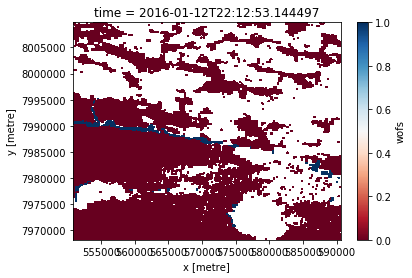

In [9]:
#plot an example scene
water_classes.isel(time = 1).wofs.plot(cmap='RdBu');

### Import tide height data 
Into pandas and concatenate each year together.

Shoreline location varies with tides, only tide heights at specific conditions are kept - determined by tide_range setting. If tide_range values at 0.00, 2.00 then only tides between 0 and 2m relative to Mean Sea Level are kept. 

In [32]:
tide_data_2017 = pd.read_csv(tide_file_2017, parse_dates=['time'], index_col='time')
#tide_data_2018 = pd.read_csv(tide_file_2018, parse_dates=['time'], index_col='time')
tide_data_2016 = pd.read_csv(tide_file_2016, parse_dates= ['time'], index_col="time")
tide_data = pd.concat([tide_data_2016, tide_data_2017])
tide_data['tide_height'] = tide_data['tide']

In [33]:
# First, we convert the data to an xarray dataset so we can analyse it in the same way as our Landsat data
tide_data_xr = tide_data.to_xarray()

# We want to convert our hourly tide heights to estimates of exactly how high the tide was at the time that
# each satellite image was taken. To do this, we can use `.interp` to 'interpolate' a tide height for each
# Landsat timestamp:

landsat_tideheights = tide_data_xr.interp(time=water_classes.time)

# We then want to put these values back into the Landsat dataset so that each image has an estimated tide height:
water_classes['tide_height'] = landsat_tideheights.tide_height

# Plot the resulting tide heights for each Landsat image:
water_classes.tide_height.plot()

plt.show()

NameError: name 'water_classes' is not defined

### Filter Landsat Images by tide height

Only keep the Landsat Images which correspond to the desired tide height.

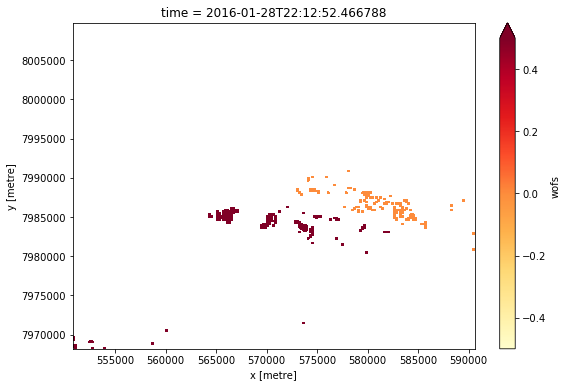

In [12]:
landsat_hightide = water_classes.where((water_classes.tide_height > tide_range[0]) & 
                                   (water_classes.tide_height < tide_range[1]), drop=True)
landsat_hightide.wofs.isel(time=3).plot(cmap='YlOrRd', size=6, vmin=-0.5, vmax=0.5)

### Create Summary Images of Water.

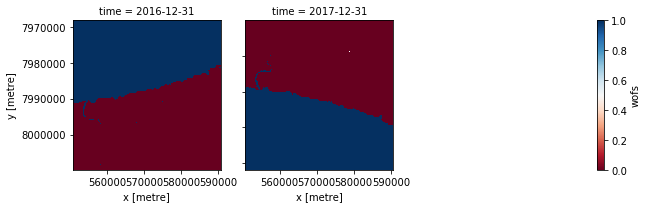

In [13]:
landsat_resampled = landsat_hightide.wofs.compute().resample(time=time_step).max('time')
landsat_resampled.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

In [14]:
#convert values to binary based on threshold of 0.5
for i in landsat_resampled.values:
    np.where(i < 0.5, i, 0*i)
    np.where(i >= 0.5, i, 0*i)

### Extract Shorelines from Imagery

Operating in single z-value, multiple arrays mode
    Extracting contour 0
    Extracting contour 1
Exporting contour shapefile to output_waterlines.shp


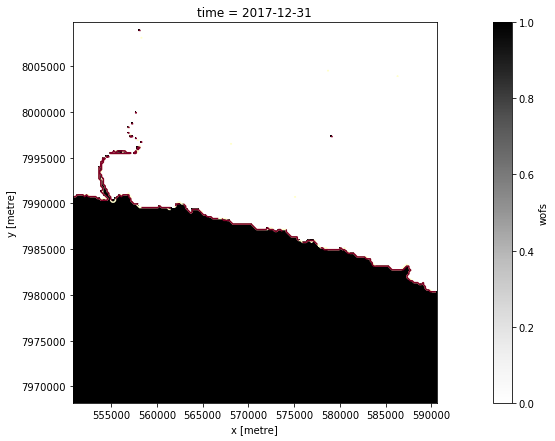

In [15]:
# Set up attributes to assign to each waterline
attribute_data = {'time': [str(i)[0:10] for i in landsat_resampled.time.values]}
attribute_dtypes = {'time': 'str'}

contour_gdf = waterline_funcs.contour_extract(
    z_values=[0.8],
    ds_array=landsat_resampled,
    ds_crs=scenes.crs,
    ds_affine=scenes.geobox.transform,
    output_shp=f'output_waterlines.shp',
    attribute_data=attribute_data,
    attribute_dtypes=attribute_dtypes,
    min_vertices=5
)


# Plot output shapefile over the top of the first year's MNDWI layer
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
landsat_resampled.isel(time=-1).plot(ax=ax, cmap='Greys', alpha=1.0, edgecolors=None)
contour_gdf.plot(cmap='YlOrRd', ax=ax)


### Plot Interactive map of output shorelines coloured by time

In [16]:
waterline_funcs.map_shapefile(gdf=contour_gdf)

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

In [17]:
client.restart()

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB
